Here, we'll be doing a runthrough of the procedure to obtain a DTM from the DEM.
For reference, the workflow will be as follows:-
1. Get DEM and trimming Shapefile.
2. Check/Assign CRS to DEM and shapefile.
3. Calculate slope of DEM, and save as file. 
4. Filter slope using either Gaussian or Box Blur. \*
5. Threshold slope file and create a mask. \*
6. Apply mask on original DEM to get ground_masked DEM
7. Sample ground_masked DEM to get a Point Vector File. \*
8. Use Point Vector file to interpolate areas in between, to get DTM. \*
9. Trim DTM and the original DEM with the trimming file. 
10. Obtain Delta DEM, such that Delta[x,y] = DEM[x,y] - DTM[x,y]
11. Plot histogram of Delta DEM, and check if it matches our expectations. 
12. Mask Delta DEM with known Topography Shapefiles. 
13. Plot histogram of masked Delta DEMs, and check if it matches our expectations. 

*Note- Steps with a * \* *indicates that there are algorithms/variables to be tuned*

In [2]:
import gdal
import cv2
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt
#Custom Written Scripts
try:
    import dem_proj as dp
    import dem_filtering as df
    import dem_perf_check as dpc
    from raster_chunks import GeoChunks as gc 
    
except ImportError:
    print("Import Error. Check if dem_filte-1 DEM Interpolation-Copy1 Last Checkpoint: a few seconds ago (autosaved)ring.py is present in PYTHONPATH")
    print("PYTHONPATH = ")
    call(["echo", "$PYTHONPATH"])


Setting up PATH variables. 

We will continue to set up PATH variables, as and when necessary.

**Skipping Steps for speed of implementation.
Come back and implement the remaining steps, later**

In [3]:
PATH_PREFIX = "/home/y13/vimana/workdir/rough/s3_dtm/"
input_DEM = PATH_PREFIX + "s3_dem.tif"
input_slope = PATH_PREFIX + "s3_slope.tif"
input_trim = PATH_PREFIX + "trim_vector/AOI-3.shp"
output_avg_slope = PATH_PREFIX + "s3_avg_slope.tif"
output_mask_DEM = PATH_PREFIX + "s3_mask.tif"

**Step 4**

Now, we average the slope, with a gaussian Filter.

In [3]:
df.gaussian_blur(in_file=input_slope,out_file=output_avg_slope)

0
Chunking with default Chunk Size of 2048 x 2048
Block Size is X , Y = 19768, 1
Chunk Size is X , Y = 2048, 2048


True

**Step 5 & 6**

We use the averaged slope, and a threshold, to mask the original DEM. 
Our assumption is that this masked DEM, is the DEM of only the ground points.



In [5]:
df.maskDEM(dem_input=input_DEM,file_output=output_mask_DEM,mask_input=output_avg_slope,val_threshold=16.0)

0
0
Chunking with default Chunk Size of 2048 x 2048
Block Size is X , Y = 19768, 1
Chunk Size is X , Y = 2048, 2048


True

Now, after some processing in QGIS (** Steps 7 & 8 ** ),
We move on to trimming, for Delta DEM

In [16]:
input_DTM = PATH_PREFIX + "s3_dtm_4.tif"
deltaDEM = PATH_PREFIX + "delta_4.tif" 
masked_DEM = PATH_PREFIX + "M_s3_dem.tif"
masked_DTM = PATH_PREFIX + "M_s3_dtm_4.tif"
masked_Delta = PATH_PREFIX + "M_delta_4.tif"


In [17]:
#dpc.apply_mask_poly(baseDEM=input_DEM, maskDEM=masked_DEM,maskPoly=input_trim)
dpc.apply_mask_poly(baseDEM=input_DTM, maskDEM=masked_DTM,maskPoly=input_trim)
dpc.match_shape_DEM(referenceDEM=masked_DEM,terrainDEM=masked_DTM)

Mask Operation Completed.
Output file present at /home/y13/vimana/workdir/rough/s3_dtm/M_s3_dtm_4.tif


In [18]:
dpc.create_delta_DEM(referenceDEM=masked_DEM,terrainDEM=masked_DTM,deltaDEM=deltaDEM)
dpc.apply_mask_poly(baseDEM=deltaDEM, maskDEM=masked_Delta,maskPoly=input_trim)


Mask Operation Completed.
Output file present at /home/y13/vimana/workdir/rough/s3_dtm/M_delta_4.tif


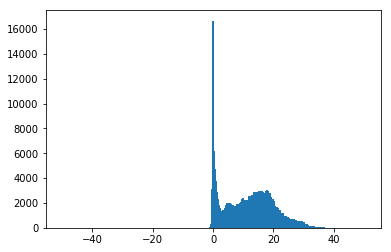

{-50.0: 0,
 -49.8998998998999: 0,
 -49.7997997997998: 0,
 -49.6996996996997: 0,
 -49.5995995995996: 0,
 -49.4994994994995: 0,
 -49.3993993993994: 0,
 -49.2992992992993: 0,
 -49.199199199199199: 0,
 -49.099099099099099: 0,
 -48.998998998998999: 0,
 -48.898898898898899: 0,
 -48.798798798798799: 0,
 -48.698698698698699: 0,
 -48.598598598598599: 0,
 -48.498498498498499: 0,
 -48.398398398398399: 0,
 -48.298298298298299: 0,
 -48.198198198198199: 0,
 -48.098098098098099: 0,
 -47.997997997997999: 0,
 -47.897897897897899: 0,
 -47.797797797797799: 0,
 -47.697697697697699: 0,
 -47.597597597597598: 0,
 -47.497497497497498: 0,
 -47.397397397397398: 0,
 -47.297297297297298: 0,
 -47.197197197197198: 0,
 -47.097097097097098: 0,
 -46.996996996996998: 0,
 -46.896896896896898: 0,
 -46.796796796796798: 0,
 -46.696696696696698: 0,
 -46.596596596596598: 0,
 -46.496496496496498: 0,
 -46.396396396396398: 0,
 -46.296296296296298: 0,
 -46.196196196196198: 0,
 -46.096096096096097: 0,
 -45.995995995995997: 0,
 -4

In [19]:
dpc.DEM_histogram(histDEM=masked_Delta)

In [21]:
import dem_performance as dpr


In [23]:
call(["mkdir","./data/"])
dpr.terrain_accuracy(demfile=masked_DEM,dtmfile=masked_DTM)

(1544382, 70211244, 97.80037795655636)

**Step 12**

Next, we will mask the Delta DEMs, and find Delta's spatially. 

In [3]:
input_Delta = PATH_PREFIX + "M_delta_5.tif"
out_Delta_Terrain = PATH_PREFIX + "MC_Delta_Terrain.tif"
out_Delta_DenseForest = PATH_PREFIX + "MC_Delta_Forest.tif"
out_Delta_Shrub = PATH_PREFIX + "MC_Delta_Shrub.tif"

Setting Up the Directories for the masks to be used...

In [14]:
terrain_Mask = PATH_PREFIX + "topo_vector/Terrain.shp"
forest_Mask = PATH_PREFIX + "topo_vector/Dense Forest.shp"
shrub_Mask = PATH_PREFIX + "topo_vector/Shrub.shp"


Processing..

In [15]:
dpc.apply_mask_poly(baseDEM=input_Delta,maskDEM=out_Delta_Terrain,maskPoly=terrain_Mask)
dpc.apply_mask_poly(baseDEM=input_Delta,maskDEM=out_Delta_DenseForest,maskPoly=forest_Mask)
dpc.apply_mask_poly(baseDEM=input_Delta,maskDEM=out_Delta_Shrub,maskPoly=shrub_Mask)

0
Mask Operation Completed.
Output file present at /home/madhavm/vimana/rough/s5_interp_test/MC_Delta_Terrain.tif
0
Mask Operation Completed.
Output file present at /home/madhavm/vimana/rough/s5_interp_test/MC_Delta_Forest.tif
0
Mask Operation Completed.
Output file present at /home/madhavm/vimana/rough/s5_interp_test/MC_Delta_Shrub.tif


0


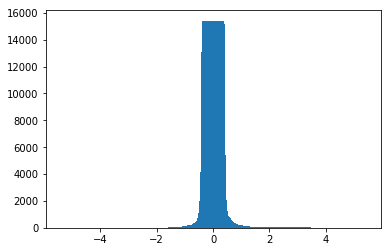

In [4]:
terr_hist = dpc.DEM_histogram(histDEM=out_Delta_Terrain,hist_min=-5,hist_max=5)

0


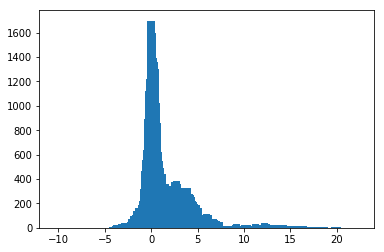

In [5]:
shrub_hist = dpc.DEM_histogram(histDEM=out_Delta_Shrub,hist_min=-10,hist_max=22)

0


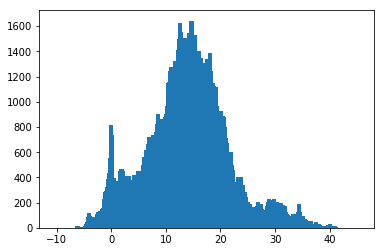

In [6]:
forest_hist = dpc.DEM_histogram(histDEM=out_Delta_DenseForest,hist_min=-10,hist_max=45)